# DenseNet的实现及在cifar10上的应用

## 导入数据集

### 导入包

In [1]:
import mxnet as mx
from mxnet import ndarray as nd
from mxnet import autograd as ag
from mxnet import init
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from mxnet.gluon.data.vision import transforms
import datetime
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


### 数据增广

In [2]:
transform_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomResizedCrop(32, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
    transforms.RandomFlipLeftRight(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

### 读取数据集

In [3]:
data_dir = 'data/cifar10/'

batch_size = 64

train_ds = vision.ImageFolderDataset(root=data_dir+'train', flag=1)
valid_ds = vision.ImageFolderDataset(root=data_dir+'valid', flag=1)

train_data = gluon.data.DataLoader(dataset=train_ds.transform_first(transform_train), 
                                   batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(dataset=valid_ds.transform_first(transform_test), 
                                   batch_size=batch_size, shuffle=False, last_batch='keep')

In [4]:
print(len(train_ds))
print(len(valid_ds))

print(len(train_data))
for data, label in train_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

45000
5000
704
(64, 3, 32, 32) (64,)

[3 7 8 8 0 5 2 0 2 7 0 6 4 9 3 9 3 4 0 4 1 1 5 8 8 7 1 7 6 1 1 8 4 5 3 4 1
 8 5 1 2 2 4 4 2 2 6 8 6 0 3 5 6 3 1 6 0 5 8 3 0 2 8 4]
<NDArray 64 @gpu(0)>


## 设计模型 --DenseNet

In [5]:
class conv_block(nn.HybridBlock):
    def __init__(self, channels, **kwargs):
        super(conv_block, self).__init__(**kwargs)
        with self.name_scope():
            net = nn.HybridSequential()
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.Conv2D(channels=4*channels, kernel_size=1, 
                              strides=1, padding=0))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.Conv2D(channels=channels, kernel_size=3, 
                              strides=1, padding=1))
        self.net = net
        
    def hybrid_forward(self, F, x):
        out = x
        for layer in self.net:
            out = layer(out)
        return out

class dense_block(nn.HybridBlock):
    def __init__(self, num_layers, k, **kwargs):
        super(dense_block, self).__init__(**kwargs)
        self.num_layers = num_layers
        with self.name_scope():
            net = nn.HybridSequential()
            for _ in range(num_layers):
                net.add(conv_block(k))
        self.net = net
    
    def hybrid_forward(self, F, x):
        for layer in self.net:
            out = layer(x)
            x = F.concat(x, out, dim=1)   # nd.concat 操作要求输入是 ndarray 但是 hybridize 后 out变成了 symbol 类型 会报错
        return x

class transition_block(nn.HybridBlock):
    def __init__(self, channels, theta=0.5, **kwargs):
        super(transition_block, self).__init__(**kwargs)
        with self.name_scope():
            net = nn.HybridSequential()
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.Conv2D(channels=int(channels*theta), kernel_size=1, 
                              strides=1, padding=0))
            net.add(nn.AvgPool2D(pool_size=2, strides=2, padding=0))
        self.net = net
        
    def hybrid_forward(self, F, x):
        out = x
        for layer in self.net:
            out = layer(out)
        return out

In [6]:
dblk = dense_block(2, 10)
dblk.initialize()

x = nd.random.uniform(shape = (4, 3, 8, 8))
print(dblk(x).shape)

tblk = transition_block(10)
tblk.initialize()

print(tblk(x).shape)

(4, 23, 8, 8)
(4, 5, 4, 4)


In [7]:
class DenseNet(nn.HybridBlock):
    def __init__(self, init_channels, dense_blocks, k, theta, num_classes, verbose=False, **kwargs):
        super(DenseNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = nn.HybridSequential()
            # stage 1
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.Conv2D(channels=init_channels, kernel_size=7, 
                              strides=2, padding=3))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # stage dense_net
            channels = init_channels
            for i, num_layers in enumerate(dense_blocks):
                net.add(dense_block(num_layers, k))
                channels += k*num_layers
                if i < len(dense_blocks) - 1:
                    net.add(transition_block(channels, theta))
                    channels = int(channels * theta)
            # stage classification
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.GlobalAvgPool2D())
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
        self.net = net
    
    def hybrid_forward(self, F, x):
        out = x
        for i, f in enumerate(self.net):
            out = f(out)
            if self.verbose:
                print('Block %d, Output %s' % (i+1, out.shape))
        return out

In [8]:
def get_net(ctx, init_channels, dense_blocks, k, theta=0.5, num_classes=1000):
    net = DenseNet(init_channels=init_channels, dense_blocks=dense_blocks, k=k, theta=theta, num_classes=num_classes)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [9]:
# net = DenseNet(init_channels=24, dense_blocks=[6, 12, 24, 16], k=12, theta=0.5, num_classes=100, verbose=True)
# net.initialize()
# net

In [10]:
# for data, label in train_data:
#     print(data.shape)
#     output = net(data)
#     break

## 交叉熵损失函数

In [11]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [12]:
ctx = mx.gpu(0)
num_epoches = 300
optimizer = 'momentum'
lr = 0.1
lr_decay = 0.1
lr_period = 150
momentum = 0.9
weight_decay = 1e-4
cost_period = 10
print_cost = True

In [13]:
init_channels = 16
dense_blocks = [6, 12, 24, 16]
k = 24
theta=0.5
num_classes=100
net = get_net(ctx, init_channels, dense_blocks, k, theta, num_classes)
net.hybridize()

Epoch 1, Train_loss: 0.418027663413, Train_acc: 0.858731356534, Valid_acc: 0.874208860759, Time 00:00:43, lr: 0.001000
Epoch 2, Train_loss: 0.428524129102, Train_acc: 0.863059303977, Valid_acc: 0.871835443038, Time 00:00:42, lr: 0.001000
Epoch 3, Train_loss: 0.444070427735, Train_acc: 0.864701704545, Valid_acc: 0.873417721519, Time 00:00:43, lr: 0.001000
Epoch 4, Train_loss: 0.4180419435, Train_acc: 0.867120916193, Valid_acc: 0.873022151899, Time 00:00:43, lr: 0.001000
Epoch 5, Train_loss: 0.346370889389, Train_acc: 0.870228160511, Valid_acc: 0.87559335443, Time 00:00:42, lr: 0.001000
Epoch 6, Train_loss: 0.381146260158, Train_acc: 0.873135653409, Valid_acc: 0.87539556962, Time 00:00:43, lr: 0.001000
Epoch 7, Train_loss: 0.468228075661, Train_acc: 0.873291015625, Valid_acc: 0.876977848101, Time 00:00:47, lr: 0.001000
Epoch 8, Train_loss: 0.433871345151, Train_acc: 0.872669566761, Valid_acc: 0.879746835443, Time 00:00:54, lr: 0.001000
Epoch 9, Train_loss: 0.351229910007, Train_acc: 0.87

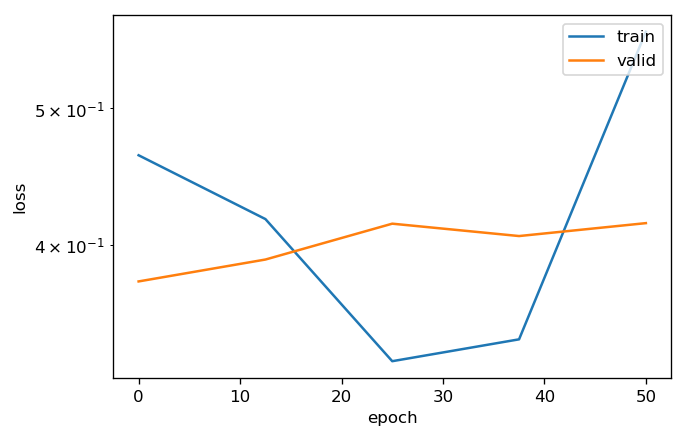

In [16]:
num_epoches =50
lr = 0.001
utils.train(net, train_data, valid_data, ctx, num_epoches, softmax_cross_entropy, optimizer, 
      lr, lr_decay, lr_period, momentum, weight_decay, 
      cost_period, print_cost)